# EBSD/TKD analysis with kikuchipy and HyperSpy

## @ NNUM in Oslo, Norway June 4, 2024

Håkon Wiik Ånes (hwaanes@gmail.com), Xnovo Technology

In this tutorial we'll characterize an on-axis transmission Kikuchi diffraction (TKD) dataset of polycrystalline gold by Hough indexing and pattern matching.
We'll evaluate our results by using geometrical TKD simulations and comparing indexing results to pre-indexing maps.

The gold dataset is kindly provided by Alice Bastos da Silva from the Technical University of Denmark (DTU).
The patterns were acquired using Bruker Nano's on-axis TKD detector and software (Esprit).

Steps:

1. Load and inspect data
2. Specify candidate phases
3. Calibrate detector-sample geometry (projection/pattern center)
4. Hough indexing
5. Dictionary indexing
6. Orientation refinement

We link to tutorials relevant for each step in the respective sections in *italic*.

Documentation of tools we use:

* kikuchipy: https://kikuchipy.org
* HyperSpy: https://hyperspy.org
* PyEBSDIndex: https://pyebsdindex.readthedocs.io
* orix: https://orix.readthedocs.io
* diffsims: https://diffsims.readthedocs.io
* EMsoft (indirectly): https://github.com/EMsoft-org/EMsoft

Import all necessary functionality

In [1]:
# Replace 'inline' for 'qt5' (from PyQt5 package) for interactive plotting
#%matplotlib qt5
%matplotlib inline

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from diffsims.crystallography import ReciprocalLatticeVector
import hyperspy.api as hs
from orix import io, plot, sampling
from orix.crystal_map import Phase, PhaseList
from orix.quaternion import Orientation, Rotation
from orix.vector import Vector3d

import kikuchipy as kp


savefig_kw = {"bbox_inches": "tight", "pad_inches": 0, "dpi": 300}

path_data = Path.cwd()
path_res = path_data / "results"
if not path_res.exists():
    path_res.mkdir()

## 1. Load and inspect data

*Relevant tutorial: https://kikuchipy.org/en/stable/tutorials/load_save_data.html.*

Load the 460 MB data into memory

In [2]:
path_tkd = path_data / "20nmAu_2019-03-12_02.hdf5"

s = kp.load(path_tkd, lazy=False)

What is the shape and size of my EBSD data?

In [3]:
s

<EBSD, title: 20nmAu_2019-03-12_02..., dimensions: (51, 61|320, 240)>

In [4]:
s.axes_manager

<Axes manager, axes: (51, 61|320, 240)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |     51 |      0 |       0 |   0.005 |     um 
               y |     61 |      0 |       0 |  0.0051 |     um 
---------------- | ------ | ------ | ------- | ------- | ------ 
              dx |    320 |      0 |       0 |      99 |     um 
              dy |    240 |      0 |       0 |      99 |     um

In [5]:
s.data.shape

(61, 51, 240, 320)

Note the flipping of dimensions here: HyperSpy uses (x, y, dx, dy), while NumPy stores the data as (y, x, dy, dx).

In [6]:
s.data.dtype

dtype('uint16')

What information about the experiment is available?

In [7]:
s.metadata

├── Acquisition_instrument
│   └── SEM
│       ├── beam_energy = 30.0
│       ├── magnification = 100000.0
│       └── working_distance = 5.026599722
├── General
│   ├── original_filename = W:\P87500-Alice\Alice2019\PenumbraFebMarch2019\20nmAu_std\Au20_Std_30KV_1-7nA_ap30_Sp5_DD5_DT5-8_HV_dyn__400p.bcf
│   └── title = 20nmAu_2019-03-12_02...
└── Signal
    └── signal_type = EBSD

In [8]:
s.original_metadata

├── CameraTilt = 5.824999998357347
├── Coordinate Systems
│   ├── ESPRIT Coordinates = array([[254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 2 ... ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254]], dtype=uint8)
│   └── ID = 5
├── DetectorFullHeightMicrons = 23700
├── DetectorFullWidthMicrons = 31600
├── Grid Type = isometric
├── KV = 30.0
├── MADMax = 1.8
├── Magnification = 100000.0
├── MapStepFactor = 1.0
├── MaxRadonBandCount = 12
├── MinIndexedBands = 5
├── NCOLS = 299
├── NPoints = 3111
├── NROWS = 258
├── OriginalFile = W:\P87500-Alice\Alice2019\PenumbraFebMarch2019\20nmAu_std\Au20_Std_30KV_1-7nA_ap30_Sp5_DD5_DT5-8_HV_dyn__400p.bcf
├── PatternHeight = 240
├── PatternWidth = 320
├── Phases
│   └── 1
│       ├── AtomPositions
│       │   └── 1 = Au,0,0,0,1,0
│       ├── Formula = Au4
│       ├── IT = 225
│       ├── LatticeConstants = array([ 4.079,  4.079,  4.079, 90.   , 90.   , 90.   ], dtype=float32)
│       ├── Name = Gold
│       ├── Setting = 1
│       └── SpaceGroup = F m#ovl3m
├── PixelByteCount = 2
├── SEPixelSizeX = 0.005002701667
├── SEPixelSizeY = 0.005083576806
├── SampleTilt = 0.0
├── StaticBackground = array([[167, 154, 157, ..., 132, 140, 145],
       [162, 165, 163, ..., 146, 1 ... .., 126, 138, 136],
       [148, 150, 153, ..., 138, 128, 128]], dtype=uint16)
├── TopClip = 0.0
├── UnClippedPatternHeight = 240
├── WD = 5.026599722
├── XSTEP = 0.005002701667
├── YSTEP = 0.005083576806
├── ZOffset = 0.0
├── manufacturer = bruker nano
└── version = esprit 2.x

kikuchipy tries to read extra information specific to EBSD:
* Detector-sample calibration
* Static background (used to enhance the Kikuchi diffraction signal)
* Orientation data (indexing results)

In [9]:
s.detector

EBSDDetector(shape=(240, 320), pc=(0.489, 0.439, -0.63), sample_tilt=0.0, tilt=5.825, azimuthal=0.0, binning=1.0, px_size=98.75 um)

In [10]:
s.static_background

array([[167, 154, 157, ..., 132, 140, 145],
       [162, 165, 163, ..., 146, 146, 137],
       [164, 160, 167, ..., 145, 139, 150],
       ...,
       [194, 154, 155, ..., 135, 123, 137],
       [153, 155, 150, ..., 126, 138, 136],
       [148, 150, 153, ..., 138, 128, 128]], dtype=uint16)

In [11]:
s.xmap

Phase   Orientations  Name  Space group  Point group  Proper point group     Color
    0  3111 (100.0%)  None         None         None                None  tab:blue
Properties: 
Scan unit: px

In [12]:
s.xmap = io.load(path_tkd)
s.xmap

Phase   Orientations         Name  Space group  Point group  Proper point group     Color
   -1     284 (9.1%)  not_indexed         None         None                None         w
    1   2827 (90.9%)         Gold        Fm-3m         m-3m                 432  tab:blue
Properties: PCX, PCY, DD, MAD, MADPhase, NIndexedBands, RadonBandCount, RadonQuality, XBEAM, YBEAM, XSAMPLE, YSAMPLE, ZSAMPLE
Scan unit: um

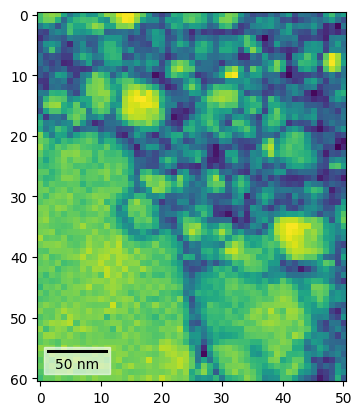

In [13]:
s.xmap.plot("RadonQuality")

We will produce our own indexing results and use most of the results from Bruker Esprit for comparison only.
The exception is the detector-sample calibration, which we will use as a starting guess for a refinement step.

### Some pre-indexing maps

*Relevant tutorials:*
* *https://kikuchipy.org/en/stable/tutorials/feature_maps.html*
* *https://kikuchipy.org/en/stable/tutorials/virtual_backscatter_electron_imaging.html*

Before indexing, it is important to:

* Evaluate the pattern quality
* Get an impression of what to expect from the indexing results

To that end, we inspect three different pre-indexing maps:

* Mean pattern intensity map
* Image quality map

Get the mean pattern intensity map by getting the average intensity within each pattern (axis 2 and 3 in our data array)

In [14]:
s_mean = s.mean(axis=(2, 3))
plt.imsave(path_res / "maps_mean.png", s_mean.data, cmap="gray")
s_mean

<BaseSignal, title: 20nmAu_2019-03-12_02..., dimensions: (51, 61|)>

Inspect patterns in this map

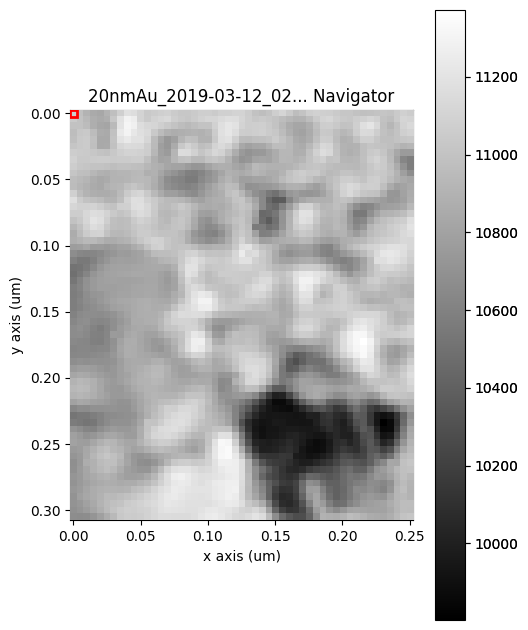

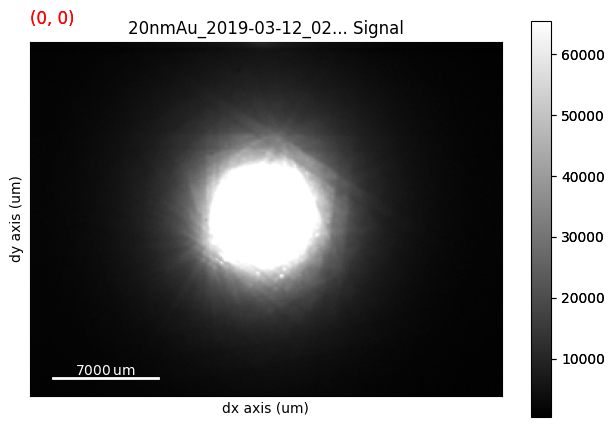

In [15]:
s.plot(navigator=s_mean)

### Enhancement of Kikuchi pattern

*Relevant tutorial: https://kikuchipy.org/en/stable/tutorials/pattern_processing.html*.

Remove static (constant) background.
Instead of using the background acquired in the vendor software, we'll obtain one by averaging all patterns.
Before removing the static background, we compare the two static backgrounds.

In [16]:
bg = s.mean(axis=(0, 1))
bg.metadata.General.title = "Our background"
bg.change_dtype(s.data.dtype)
bg

<EBSD, title: Our background, dimensions: (|320, 240)>

In [17]:
bg2 = kp.signals.EBSD(s.static_background)
bg2.metadata.General.title = "Bruker's background"
print(bg2)
bg2.downsample(5)
bg2

<EBSD, title: Bruker's background, dimensions: (|1600, 1200)>
[########################################] | 100% Completed | 105.81 ms


<EBSD, title: Bruker's background, dimensions: (|320, 240)>

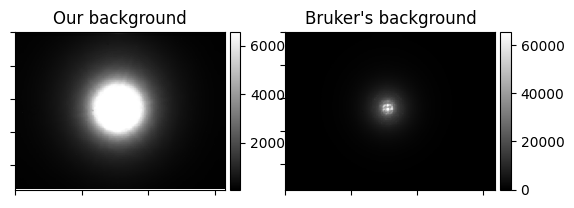

In [18]:
_ = hs.plot.plot_images([bg, bg2], axes_decor=None)

In [19]:
s.remove_static_background(operation="divide", static_bg=bg.data)

[########################################] | 100% Completed | 105.94 ms


Inspect a few (computed on the fly) statically corrected patterns

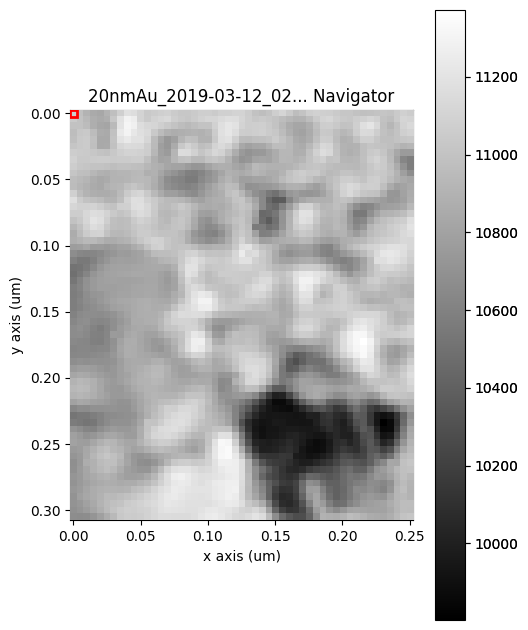

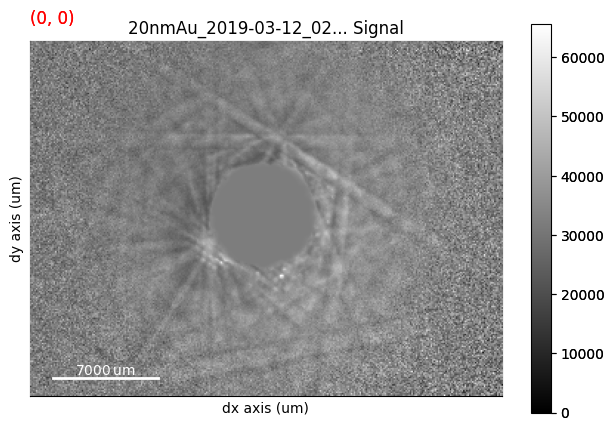

In [20]:
s.plot(s_mean)

Save corrected patterns

In [21]:
#s.save("patterns.h5")

### More pre-indexing maps

Get image quality $Q$ map (not image quality IQ from Hough indexing!)

In [22]:
maps_iq = s.get_image_quality()
plt.imsave(path_res / "maps_iq.png", maps_iq, cmap="gray")

[########################################] | 100% Completed | 523.29 ms


Navigate patterns in $Q$ map

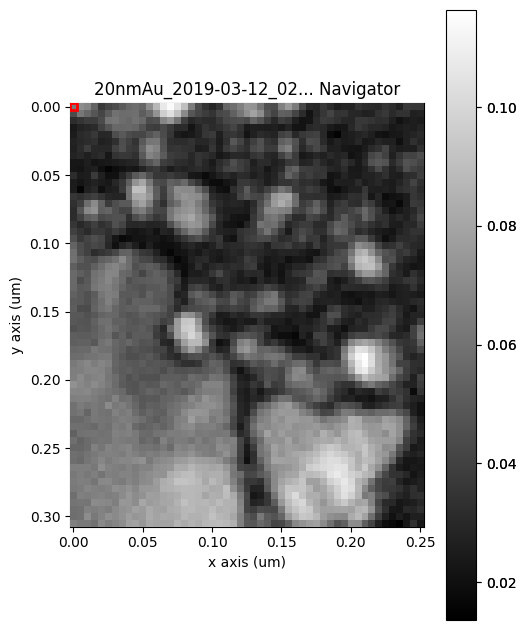

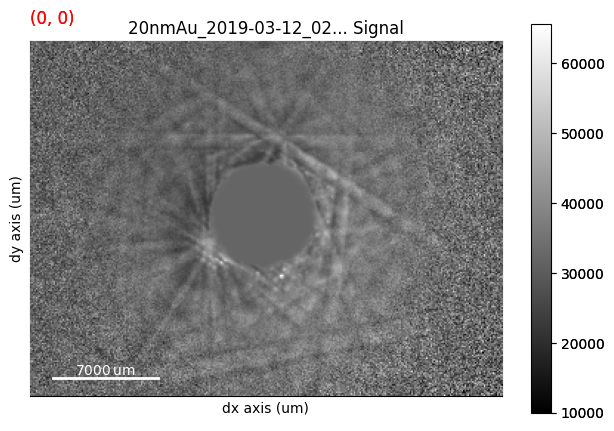

In [23]:
s.plot(hs.signals.Signal2D(maps_iq), vmin=10_000)

## 2. Specify candidate phases

*Relevant tutorial: https://kikuchipy.org/en/stable/tutorials/kinematical_ebsd_simulations.html.*

We do not expect other phases than nickel.
We will load the master pattern of nickel (packaged with kikuchipy) created with EMsoft

In [24]:
path_mp = path_data / "au_mc_mp_tkd_30kv.h5"

mp = kp.load(path_mp, energy=30, projection="lambert")

mp.phase.name = "au"
mp

<EBSDMasterPattern, title: au_mc_mp_tkd_30kv, dimensions: (|1001, 1001)>

Create a phase list for use in Hough indexing, and set the lattice parameters to Ångström

In [25]:
pl = PhaseList(mp.phase)
lat = pl["au"].structure.lattice
lat.setLatPar(lat.a * 10, lat.b * 10, lat.c * 10)

pl

Id  Name  Space group  Point group  Proper point group     Color
 0    au        Fm-3m         m-3m                 432  tab:blue

Also, load the stereographic projection which we will plot later to understand a bit more about simulations

In [26]:
mp_sp = kp.load(path_mp, energy=30, projection="stereographic")

If we have PyVista (and VTK) installed, we can inspect the Kikuchi sphere in 3D

In [27]:
#mp_sp.plot_spherical(style="points", plotter_kwargs={"notebook": False})

Otherwise, we'll have to live with the 2D stereographic projection

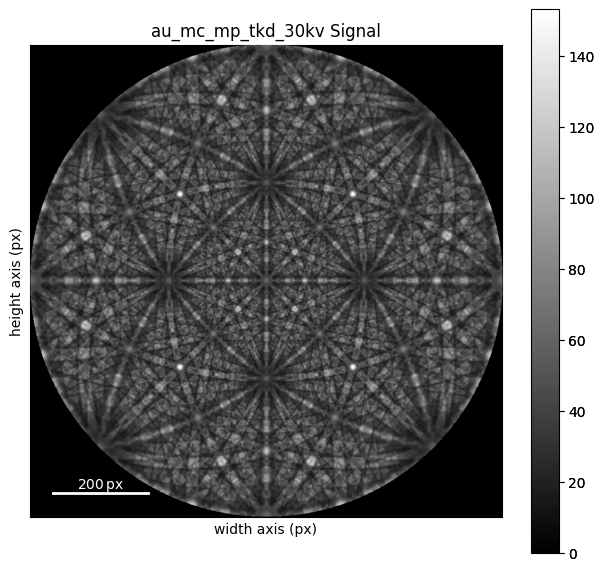

In [28]:
mp_sp.plot()

## 3. Calibrate detector-sample geometry

*Relevant tutorials:*
* *https://kikuchipy.org/en/stable/tutorials/reference_frames.html*
* *https://kikuchipy.org/en/stable/tutorials/pc_extrapolate_plane.html*
* *https://kikuchipy.org/en/stable/tutorials/pc_fit_plane.html*
* *https://kikuchipy.org/en/stable/tutorials/pc_calibration_moving_screen_technique.html*
* *https://kikuchipy.org/en/stable/tutorials/pc_orientation_dependence.html*

kikuchipy's reference frames (taken from the documentation):

<img src="https://kikuchipy.org/en/stable/_images/sample_detector_geometry.png" width="700">

Inspect calibration read from the vendor

In [29]:
s.detector.sample_tilt = 90.0
s.detector

EBSDDetector(shape=(240, 320), pc=(0.489, 0.439, -0.63), sample_tilt=90.0, tilt=5.825, azimuthal=0.0, binning=1.0, px_size=98.75 um)

Orientation of detector with respect to the sample:
* Known (fixed):
    * Sample tilt $\sigma$ = 90.0 degrees
    * Camera tilt $\theta$ = 5.83 degrees
* Unknown (but with a good guess):
    * Projection center (PCx, PCy, PCz): Shortest distance from source point to detector

Find good-quality calibration patterns to get a mean PC for the data

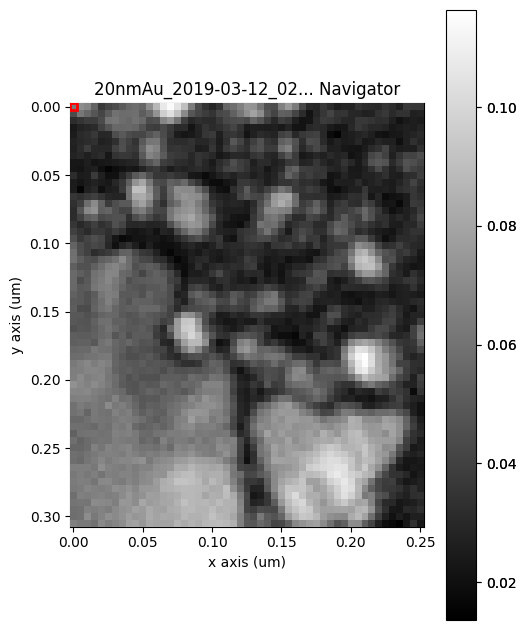

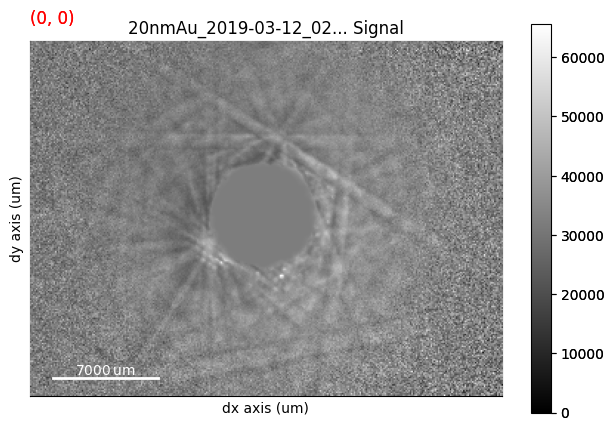

In [30]:
s.plot(hs.signals.Signal2D(maps_iq))

In [31]:
xy = [
    (14, 0),
    (10, 12),
    (17, 32),
    (15, 53),
    (37, 51),
    (42, 37),
    (42, 22),
]
p_cal = np.zeros((len(xy),) + s.detector.shape, dtype=s.data.dtype)
for i, (x, y) in enumerate(xy):
    p_cal[i] = s.data[y, x]
s_cal = kp.signals.EBSD(p_cal, detector=s.detector)

for i, name in zip(range(3), ["x", "dx", "dy"]):
    s_cal.axes_manager[i].name = name

Plot pattern positions in an overview image (specific to NORDIF acquisition software)

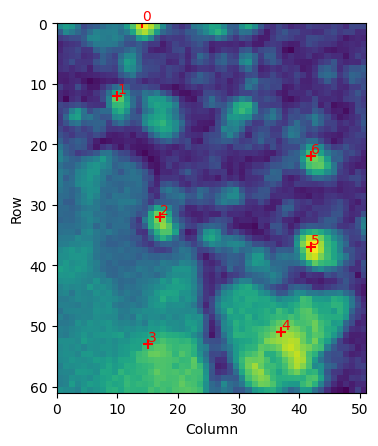

In [32]:
rc = np.array(xy)[:, ::-1]

fig = kp.draw.plot_pattern_positions_in_map(
    rc=rc,
    roi_shape=maps_iq.shape,
    roi_image=maps_iq,
    color="r",
    return_figure=True,
)
fig.savefig(path_res / "calibration_pattern_positions.png", **savefig_kw)

Inspect calibration patterns

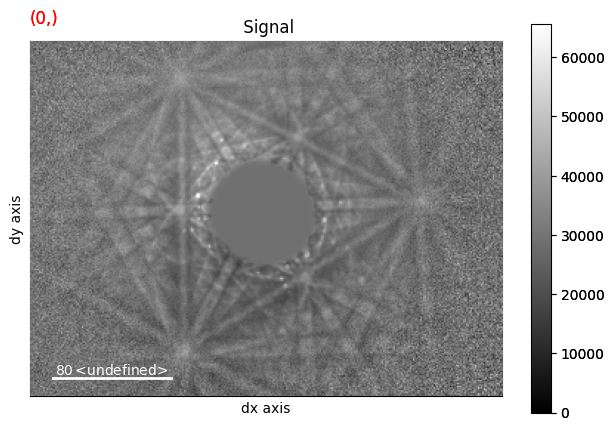

In [33]:
s_cal.plot(None)

Now we're ready to make validate our calibration (estimates of the projection centers, PCs).
We do this by optimizing the PCs and use these to Hough index our calibration patterns.

Hough indexing requires us to select a few strongly scattering reflections.
We select the four typically brighest reflections for gold

In [34]:
g = ReciprocalLatticeVector(pl["au"], hkl=[[1, 1, 1], [2, 0, 0], [2, 2, 0], [3, 1, 1]])
g = g.symmetrise()
g.sanitise_phase()  # Complete unit cell
g.calculate_structure_factor()
g.calculate_theta(30e3)
g.print_table()

 h k l      d     |F|_hkl   |F|^2   |F|^2_rel   Mult 
 1 1 1    2.356    27.0     727.6     100.0      8   
 2 0 0    2.040    24.5     599.5      82.4      6   
 2 2 0    1.442    18.3     334.9      46.0      12  
 3 1 1    1.230    15.5     241.3      33.2      24  


Create a simulator to inspect the reflectors on the Kikuchi sphere (and for later simulations)

In [35]:
simulator = kp.simulations.KikuchiPatternSimulator(g)

Plot simulator

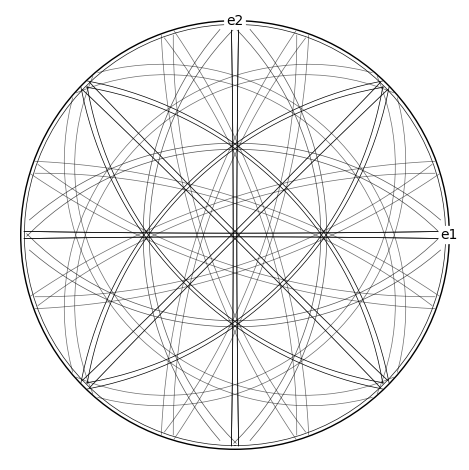

In [36]:
simulator.plot(mode="bands", axes_labels=["e1", "e2"])

Generate an indexer for PC optimization and Hough indexing (required by PyEBSDIndex)

In [37]:
indexer_cal = s_cal.detector.get_indexer(pl, g)

Optimize PC by trial and error (the initial guess is based on previous experiments on the same microscope)

In [38]:
s.detector

EBSDDetector(shape=(240, 320), pc=(0.489, 0.439, -0.63), sample_tilt=90.0, tilt=5.825, azimuthal=0.0, binning=1.0, px_size=98.75 um)


PC found: [********* ] 7/7  global best:0.107  PC opt:[ 0.4828  0.4318 -0.638 ]]
Mean PC:
 [ 0.48335324  0.43002965 -0.63109421]
Std:
 [0.00309476 0.0075225  0.0043289 ] 

All PCs:
 [[ 0.4892281   0.44540538 -0.63507333]
 [ 0.48049196  0.43195464 -0.63339105]
 [ 0.48662563  0.43094157 -0.62949303]
 [ 0.48239989  0.42604325 -0.63015386]
 [ 0.48024992  0.42417368 -0.62675632]
 [ 0.48168669  0.41993049 -0.62477704]
 [ 0.48279046  0.43175854 -0.63801482]]
Hough indexing with PyEBSDIndex information:
  PyOpenCL: True
  Projection center (Bruker, mean): (0.4834, 0.43, -0.6311)
  Indexing 7 pattern(s) in 1 chunk(s)
Radon Time: 0.008362041000509635
Convolution Time: 0.01167212499967718
Peak ID Time: 0.013990957999340026
Band Label Time: 0.01563283399991633
Total Band Find Time: 0.04971220799961884
Band Vote Time:  0.18911166599900753
  Indexing speed: 28.11513 patterns/s

All indexed: True 

Finding bands that are in some pattern:
[########################################] | 100% Completed | 

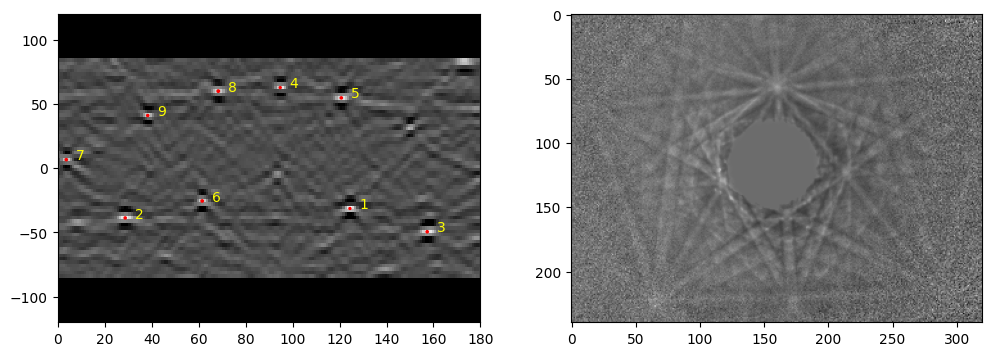

In [39]:
det_cal = s_cal.hough_indexing_optimize_pc([0.49, 0.44, -0.63], indexer_cal, batch=True, method="PSO")

# Print PCs and standard deviations
print("Mean PC:\n", det_cal.pc_average)
print("Std:\n", det_cal.pc.std(axis=0), "\n")
print("All PCs:\n", det_cal.pc)

# Get new indexer from detector, using the average PC
indexer_cal2 = det_cal.get_indexer(pl)

# Index calibration patterns using found PCs
xmap_cal = s_cal.hough_indexing(pl, indexer_cal2, verbose=2)
print("\nAll indexed:", xmap_cal.is_indexed.all(), "\n")

# Create geometrical simulations for each pattern
sim_cal = simulator.on_detector(det_cal, xmap_cal.rotations)

Plot patterns with markers

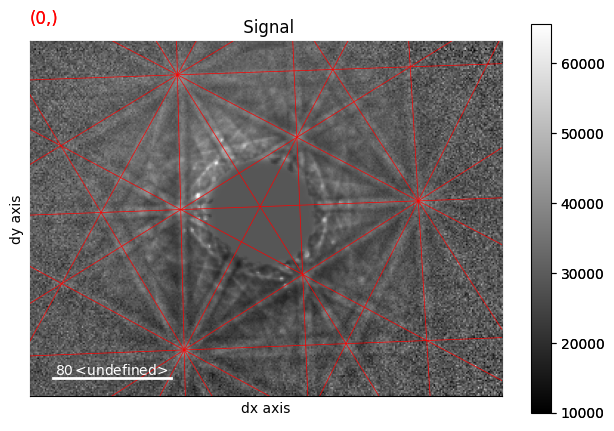

In [40]:
#del s_cal.metadata.Markers  # Uncomment to delete previous markers
markers = sim_cal.as_markers(lines_kwargs={"linewidth": 0.5, "color": "r"})
s_cal.add_marker(markers, plot_marker=False, permanent=True)
s_cal.plot(None, vmin=10_000)

Plot pair of PC coordinates and compare to the map of PC positions from above

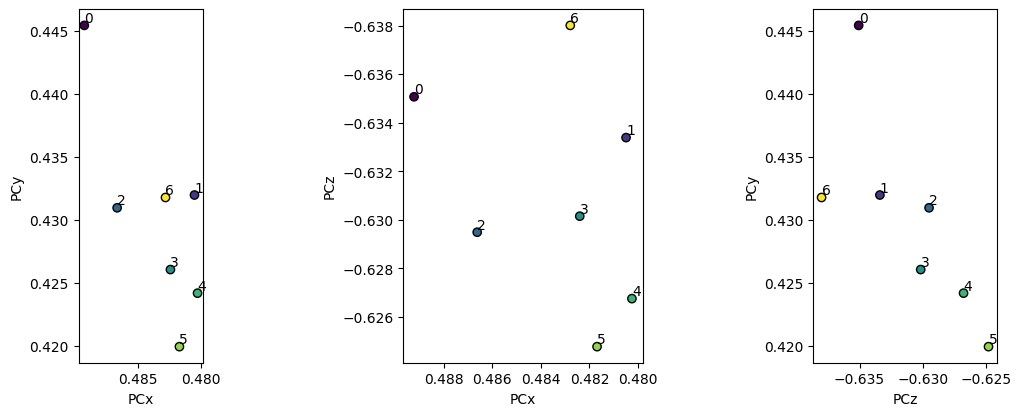

In [41]:
det_cal.plot_pc("scatter", annotate=True)

Refine PCs using pattern matching

In [42]:
xmap_cal2, det_cal2 = s_cal.refine_orientation_projection_center(
    xmap_cal,
    det_cal,
    mp,
    energy=30,
    method="LN_NELDERMEAD",  # Comment to use SciPy instead
    trust_region=[5, 5, 5, 0.1, 0.1, 0.1],
    chunk_kwargs={"chunk_shape": 1},  # One pattern per CPU
)

# Create geometrical simulations for each pattern
sim_cal2 = simulator.on_detector(det_cal2, xmap_cal2.rotations)

Refinement information:
  Method: LN_NELDERMEAD (local) from NLopt
  Trust region (+/-): [5.  5.  5.  0.1 0.1 0.1]
  Relative tolerance: 0.0001
Refining 7 orientation(s) and projection center(s):
[########################################] | 100% Completed | 944.23 ms
Refinement speed: 7.38607 patterns/s
Finding bands that are in some pattern:
[########################################] | 100% Completed | 105.77 ms
Finding zone axes that are in some pattern:
[########################################] | 100% Completed | 101.83 ms
Calculating detector coordinates for bands and zone axes:
[########################################] | 100% Completed | 106.51 ms


Again, plot patterns with markers

In [43]:
markers2 = sim_cal2.as_markers(lines_kwargs={"linewidth": 0.5, "color": "w"})
s_cal.add_marker(markers2, plot_marker=False, permanent=True)

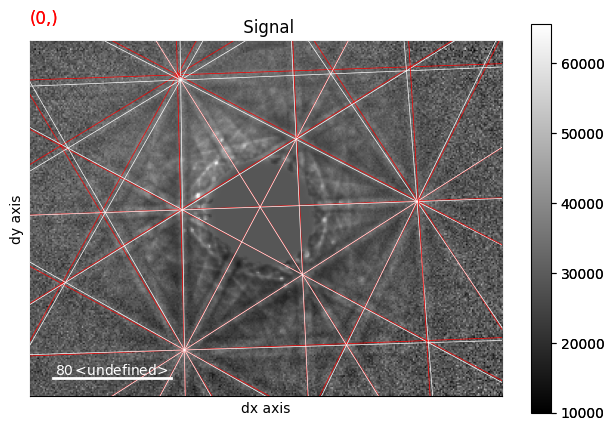

In [44]:
s_cal.plot(None, vmin=10_000)

We can also compare dynamically simulated equivalents of the experimental patterns

In [45]:
sim_cal = mp.get_patterns(xmap_cal2.rotations, det_cal2, compute=True)
sim_cal

[########################################] | 100% Completed | 105.70 ms


<EBSD, title: , dimensions: (7|320, 240)>

Remove the line markers and stretch intensities for the best visual comparison

In [46]:
del s_cal.metadata.Markers

s_cal2 = s_cal.deepcopy()
s_cal2.normalize_intensity(dtype_out="float32")
sim_cal2 = sim_cal.deepcopy()
sim_cal2.normalize_intensity(dtype_out="float32")

[########################################] | 100% Completed | 105.72 ms
[########################################] | 100% Completed | 105.97 ms


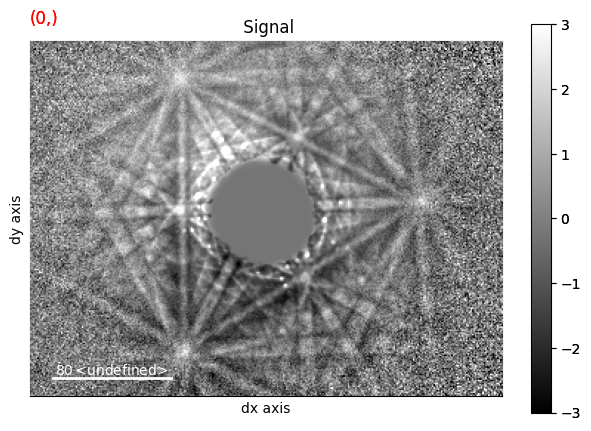

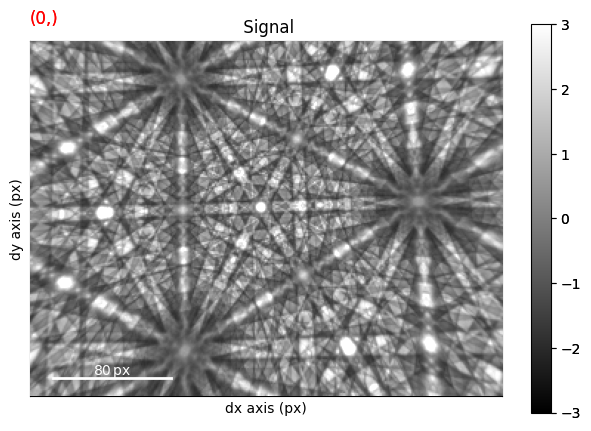

In [47]:
hs.plot.plot_signals([s_cal2, sim_cal2], navigator=None, vmin=-3, vmax=3)

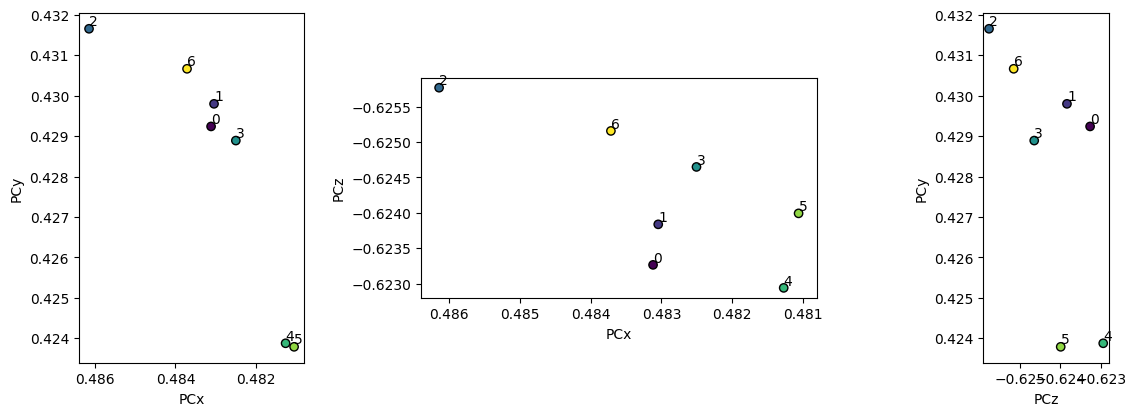

In [48]:
det_cal2.plot_pc("scatter", annotate=True)

Save detector

In [49]:
det_cal2.save(path_res / "det_cal.txt")

When the map covers a large area on the sample, the PC moves quite a lot on the detector.
This is not the case here, as our map covers about x$ x $y$ = 305 x 255 um^2.
It is therefore valid to use a single PC for the whole map, which we will do in the following.

In [50]:
det1 = det_cal2.deepcopy()
det1.pc = det1.pc_average

## 4. Hough indexing

*Relevant tutorials:*
* *https://kikuchipy.org/en/stable/tutorials/hough_indexing.html#*
* *https://kikuchipy.org/en/stable/tutorials/hybrid_indexing.html*
* *https://pyebsdindex.readthedocs.io/en/latest/tutorials/ebsd_index_demo.html*

Create a new indexer with the single PC

In [51]:
indexer = det1.get_indexer(pl, g)

Hough index all patterns

Hough indexing with PyEBSDIndex information:
  PyOpenCL: True
  Projection center (Bruker): (0.483, 0.4283, -0.6242)
  Indexing 3111 pattern(s) in 6 chunk(s)
Radon Time: 0.14962975100024778
Convolution Time: 0.10318779299814196
Peak ID Time: 0.12583904200255347
Band Label Time: 0.4672850010010734
Total Band Find Time: 0.8672930829998222
Band Vote Time:  0.5158984589997999
  Indexing speed: 2214.02340 patterns/s


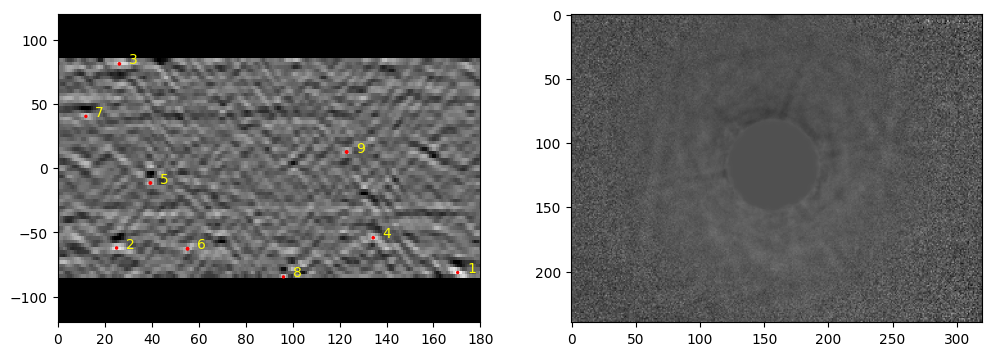

In [52]:
xmap_hi = s.hough_indexing(pl, indexer, verbose=2)

Check whether any patterns could not be indexed

In [53]:
xmap_hi

Phase   Orientations         Name  Space group  Point group  Proper point group     Color
   -1      17 (0.5%)  not_indexed         None         None                None         w
    0   3094 (99.5%)           au        Fm-3m         m-3m                 432  tab:blue
Properties: fit, cm, pq, nmatch
Scan unit: um

Save the Hough indexing results

In [54]:
io.save(path_res / "xmap_hi.h5", xmap_hi, overwrite=True)

Plot the indexing quality metrics per pattern

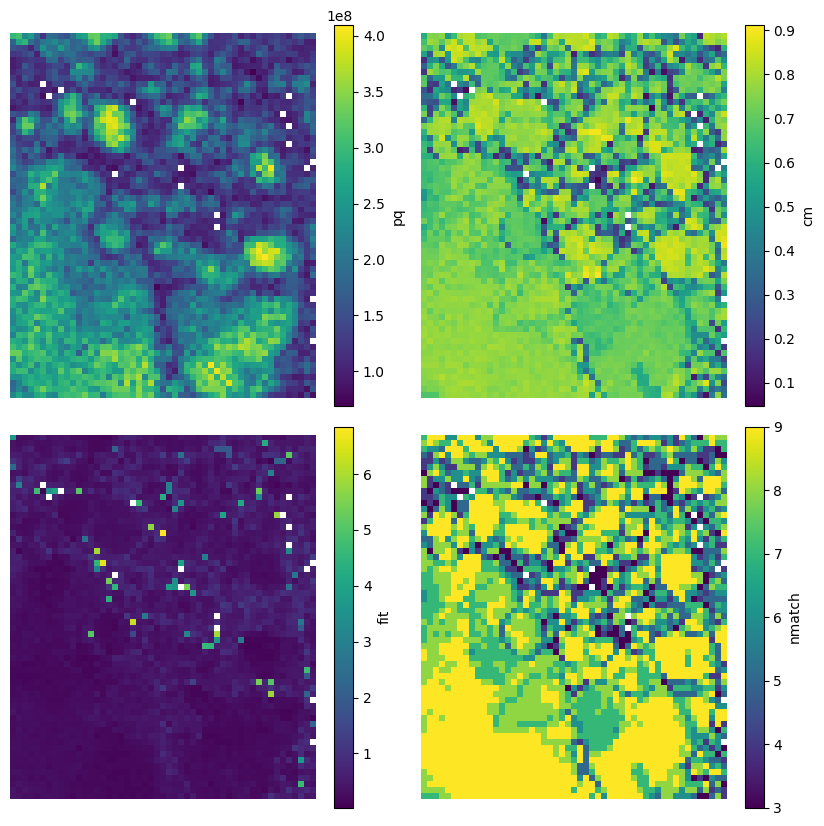

In [55]:
aspect_ratio = xmap_hi.shape[1] / xmap_hi.shape[0]
figsize = (10 * aspect_ratio, 10 * aspect_ratio)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=figsize, layout="tight")
for ax, to_plot in zip(axes.ravel(), ["pq", "cm", "fit", "nmatch"]):
    im = ax.imshow(xmap_hi["indexed"].get_map_data(to_plot))
    fig.colorbar(im, ax=ax, label=to_plot)
    ax.axis("off")

Histograms

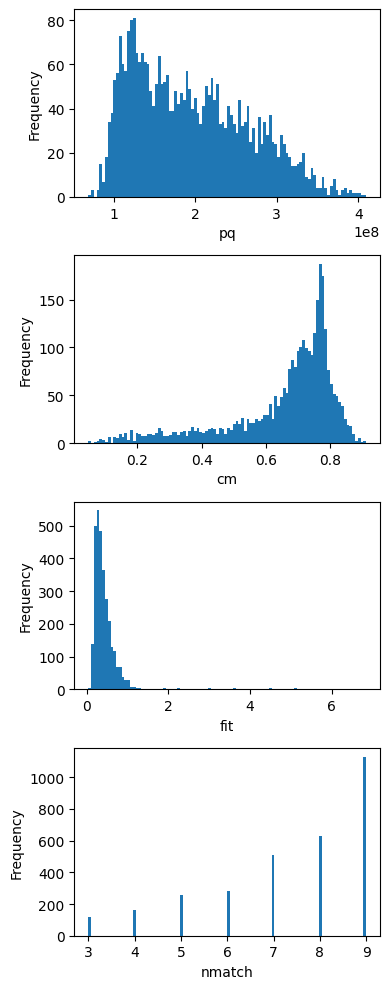

In [56]:
fig, axes = plt.subplots(nrows=4, figsize=(4, 10), layout="tight")
for ax, to_plot in zip(axes.ravel(), ["pq", "cm", "fit", "nmatch"]):
    _ = ax.hist(xmap_hi["indexed"].prop[to_plot], bins=100)
    ax.set(xlabel=to_plot, ylabel="Frequency")
    if to_plot == "pq":
        ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))

Plot the inverse pole figure IPF-Z map, where colors are given by the (symmetry reduced) crystal direction $\mathbf{t} = [uvw]$ pointing into-plane

In [57]:
ckey = plot.IPFColorKeyTSL(xmap_hi.phases[0].point_group, direction=Vector3d([0, 0, 1.]))

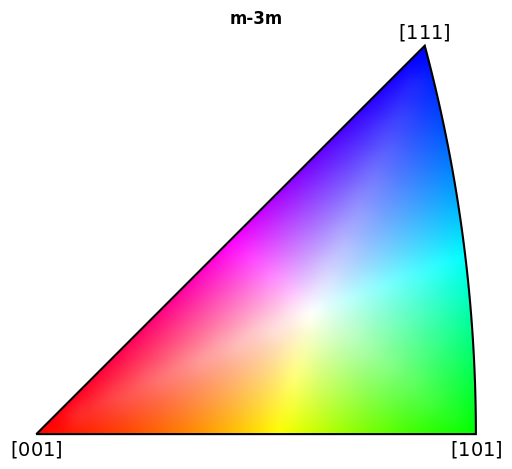

In [58]:
ckey.plot()

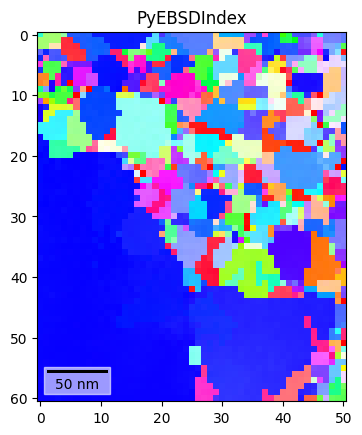

In [59]:
rgb_hi = ckey.orientation2color(xmap_hi.rotations)
fig_hi = xmap_hi.plot(rgb_hi, return_figure=True)
fig_hi.axes[0].set_title("PyEBSDIndex");

Plot the IPF-Z map overlayed with the confidence metric

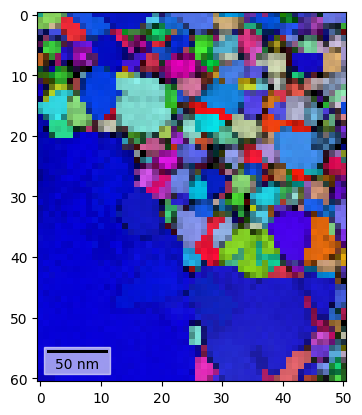

In [60]:
xmap_hi.plot(rgb_hi, overlay="cm")

Compare to the results from Bruker's software

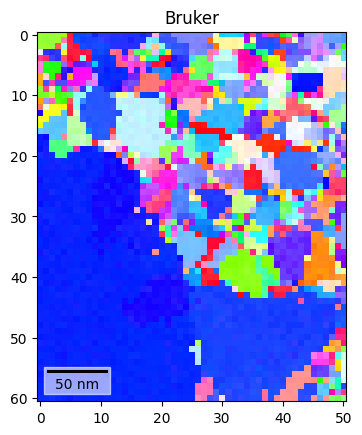

In [61]:
R_bruker = s.xmap.rotations
R_bruker2kp = Rotation.from_axes_angles([0, 0, 1], 90, degrees=True)

rgb_bruker = ckey.orientation2color(R_bruker * R_bruker2kp)
fig_bruker = s.xmap.plot(rgb_bruker, return_figure=True)
fig_bruker.axes[0].set_title("Bruker");

Evaluate results by plotting geometrical simulations on top of patterns

In [62]:
# Temporary fix for a bug!
s.axes_manager["dx"].scale = s.axes_manager["dy"].scale = 1.

In [63]:
sim_hi = simulator.on_detector(det1, xmap_hi.rotations.reshape(*xmap_hi.shape))

Finding bands that are in some pattern:
[########################################] | 100% Completed | 105.61 ms
Finding zone axes that are in some pattern:
[########################################] | 100% Completed | 105.91 ms
Calculating detector coordinates for bands and zone axes:
[########################################] | 100% Completed | 103.92 ms


In [64]:
#del s.metadata.Markers  # Uncomment to delete previously added markers
markers = sim_hi.as_markers(lines_kwargs={"linewidth": 0.5})
s.add_marker(markers, permanent=True, plot_marker=False)

Create a navigator from the IPF-Z map

In [65]:
maps_ipf = kp.draw.get_rgb_navigator(rgb_hi.reshape(xmap_hi.shape + (3,)))

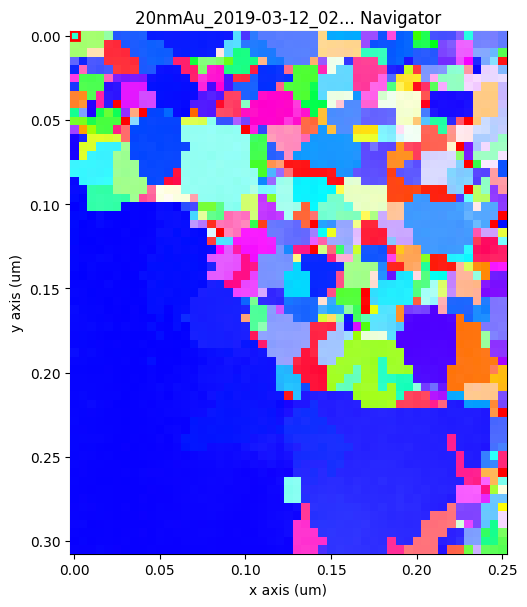

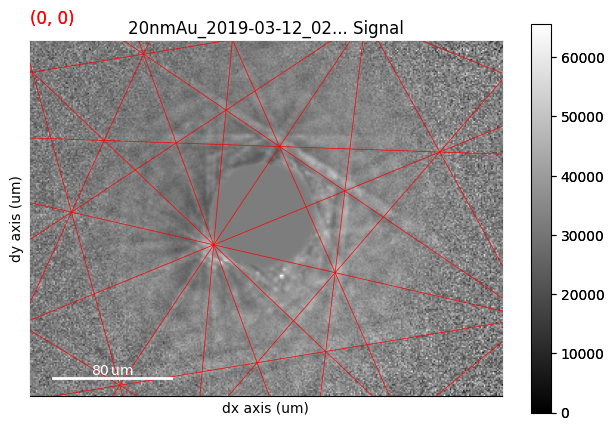

In [66]:
s.plot(maps_ipf)

## 5. Dictionary indexing

Dictionary indexing is more robust towards noise in EBSD patterns (resulting from e.g. overlapping bands, high degree of deformation etc.) than Hough indexing.
A dictionary consists of a series of (dynamically) simulated patterns projected from a master pattern, and we compare all experimental patterns to all these.

To create this dictionary, we need:

* Accurate detector-sample geometry (already done!)
* Master pattern (in the square Lambert projection)
* Sampling of all possible orientations (per phase)

Plot our geometrical simulation on top of the upper stereographic projection of our dynamically simulated Ni Kikuchi sphere

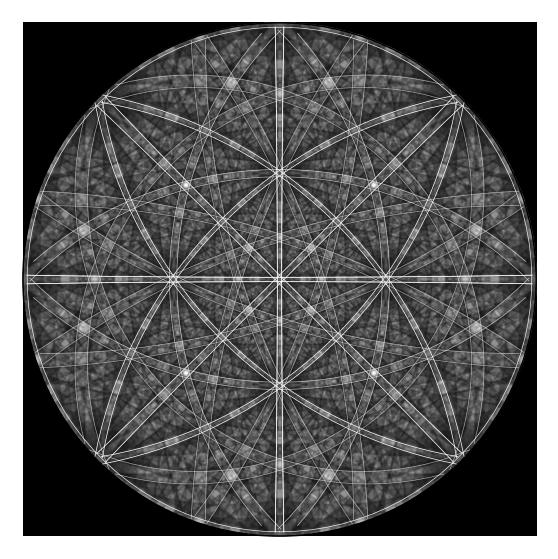

In [67]:
fig, ax = plt.subplots(subplot_kw={"projection": "stereographic"}, figsize=(7, 7))
simulator.plot(mode="bands", color="w", figure=fig)
ax.imshow(mp_sp.data, cmap="gray", extent=(-1, 1, -1, 1));

Discretely sample the complete orientation space of point group $m\bar{3}m$ (*Oh*) with an average misorientation of about 2$^{\circ}$ between rotations $\mathbf{g}$

In [68]:
R_sample = sampling.get_sample_fundamental(
    resolution=2, point_group=mp.phase.point_group
)
O_sample = Orientation(R_sample, symmetry=mp.phase.point_group)

In [69]:
O_sample

Orientation (100347,) m-3m
[[ 0.8541 -0.3536 -0.3536 -0.1435]
 [ 0.8541 -0.3536 -0.3536  0.1435]
 [ 0.8541 -0.3536 -0.1435 -0.3536]
 ...
 [ 0.8541  0.3536  0.1435  0.3536]
 [ 0.8541  0.3536  0.3536 -0.1435]
 [ 0.8541  0.3536  0.3536  0.1435]]

Plot a subset of sampled orientations in axis-angle space

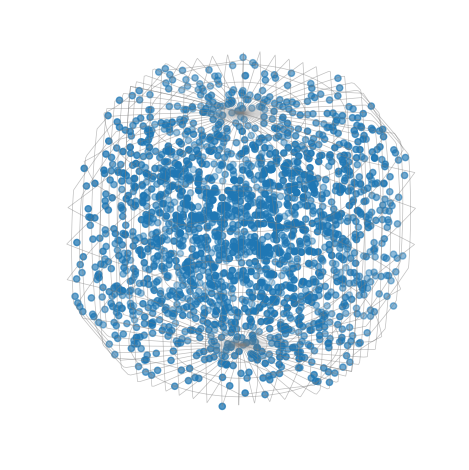

In [70]:
O_sample.get_random_sample(2000).scatter()

Bin patterns

In [71]:
s2 = s.downsample(2, inplace=False)
s2

[########################################] | 100% Completed | 105.91 ms


<EBSD, title: 20nmAu_2019-03-12_02..., dimensions: (51, 61|160, 120)>

In [72]:
det2 = det1.deepcopy()
det2.shape = s2.axes_manager.signal_shape[::-1]

Set up generation of the dictionary of dynamically simulated patterns

In [73]:
s_dict = mp.get_patterns(R_sample, det2, energy=30, chunk_shape=1000)
s_dict

<LazyEBSD, title: , dimensions: (100347|160, 120)>

Inspect the five first patterns in the dictionary

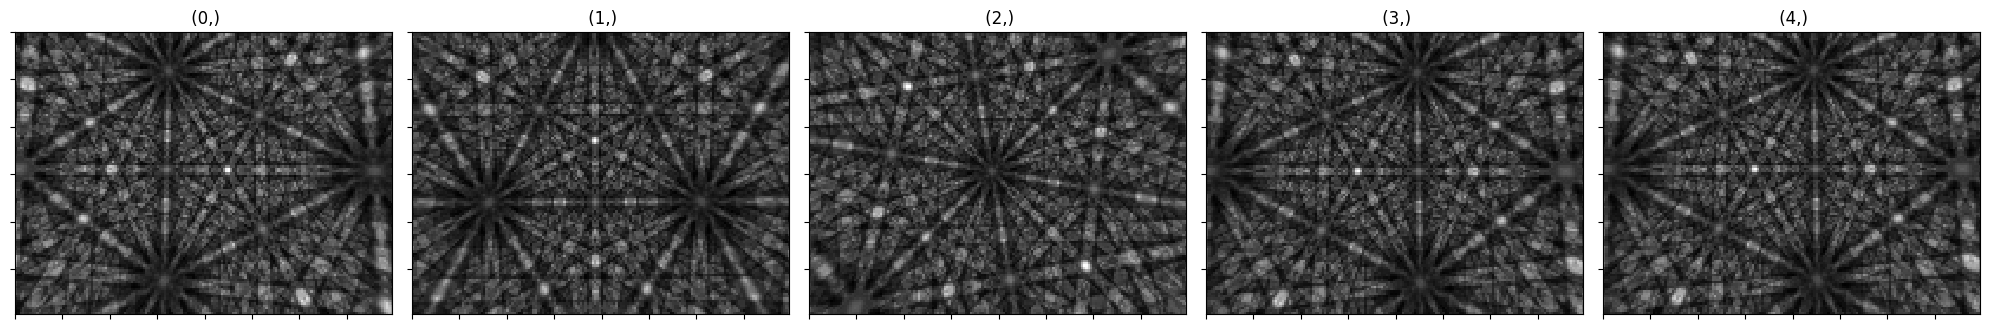

In [74]:
fig = plt.figure(figsize=(20, 4), layout="tight")
hs.plot.plot_images(s_dict.inav[:5], axes_decor=None, per_row=5, fig=fig, colorbar=False);

Perform dictionary indexing by generating a chunk of simulated patterns at a time and compare them to all the experimental patterns

In [75]:
xmap_di = s2.dictionary_indexing(s_dict)

Dictionary indexing information:
  Phase name: au
  Matching 3111 experimental pattern(s) to 100347 dictionary pattern(s)
  NormalizedCrossCorrelationMetric: float32, greater is better, rechunk: False, navigation mask: False, signal mask: False


100%|█████████████████████████████████████████████████████████████████| 101/101 [01:30<00:00,  1.11it/s]


  Indexing speed: 34.22230 patterns/s, 3434105.04990 comparisons/s


In [76]:
xmap_di

Phase   Orientations  Name  Space group  Point group  Proper point group     Color
    0  3111 (100.0%)    au        Fm-3m         m-3m                 432  tab:blue
Properties: scores, simulation_indices
Scan unit: um

The 20 best matches (rotations, scores and simulation indices) are kept

In [77]:
xmap_di.scores.shape

(3111, 20)

Plot similarity scores (normalized cross-correlation, NCC) between best matching
experimental and simulated patterns

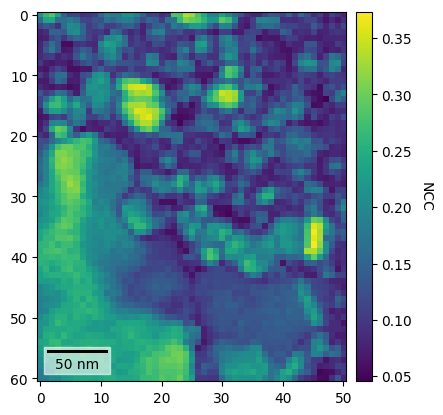

In [78]:
xmap_di.plot(xmap_di.scores[:, 0], colorbar=True, colorbar_label="NCC")

Plot IPF-Z orientation map

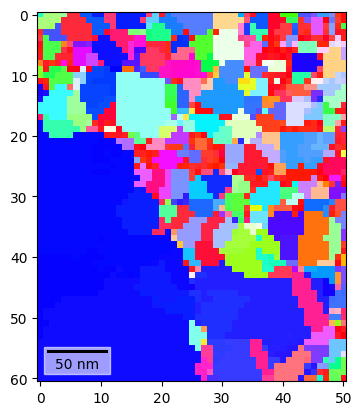

In [79]:
rgb_di = ckey.orientation2color(xmap_di.rotations[:, 0])
xmap_di.plot(rgb_di)

Plot IPF-Z orientation map with scores

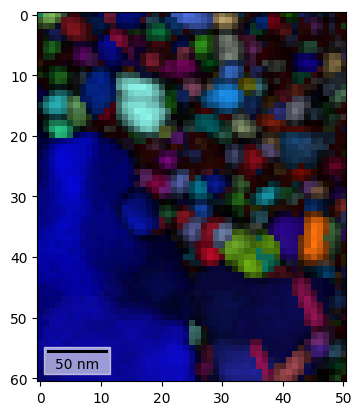

In [80]:
xmap_di.plot(rgb_di, overlay=xmap_di.scores[:, 0])

Save dictionary indexing results to file

In [81]:
io.save(path_res / "xmap_di.h5", xmap_di, overwrite=True)

## 6. Orientation refinement

During refinement, a better score $r$ is searched for iteratively by changing the orientation (and/or PC) slightly in a controlled manner using an optimization algorithm.
The default algorithm is the Nelder-Mead simplex from SciPy.
We here use that from the NLopt package (an optional dependency of kikuchipy), which has been found to be faster but equally accurate.

In [82]:
xmap_ref = s.refine_orientation(
    xmap=xmap_di,
    detector=det1,
    master_pattern=mp,
    energy=30,
    method="LN_NELDERMEAD",  # Comment to use SciPy instead
    trust_region=[2, 2, 2],
    rechunk=True,
)

Refinement information:
  Method: LN_NELDERMEAD (local) from NLopt
  Trust region (+/-): [2 2 2]
  Relative tolerance: 0.0001
Refining 3111 orientation(s):
[########################################] | 100% Completed | 94.48 ss
Refinement speed: 32.92482 patterns/s


In [83]:
xmap_ref

Phase   Orientations  Name  Space group  Point group  Proper point group     Color
    0  3111 (100.0%)    au        Fm-3m         m-3m                 432  tab:blue
Properties: scores, num_evals
Scan unit: um

Plot refined orientation map

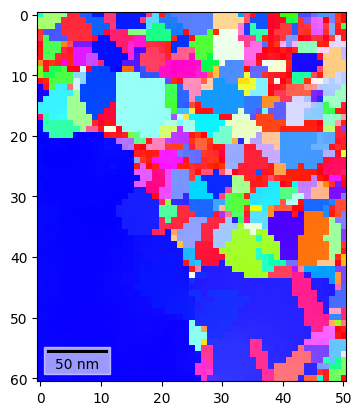

In [84]:
rgb_ref = ckey.orientation2color(xmap_ref.rotations)
xmap_ref.plot(rgb_ref)

Plot map with refined NCC scores

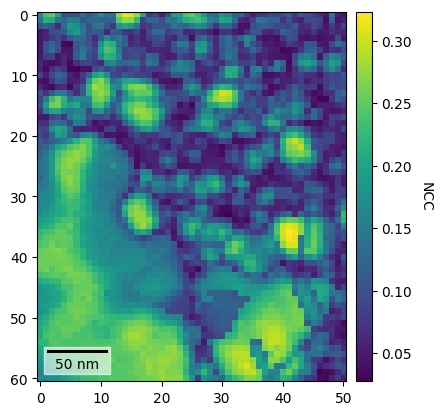

In [85]:
xmap_ref.plot(xmap_ref.scores, colorbar=True, colorbar_label="NCC")

Plot orientation map with scores overlayed

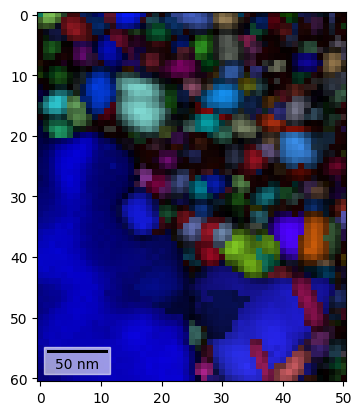

In [86]:
xmap_ref.plot(rgb_ref, overlay="scores")

Compare histogram of scores after DI and refinement

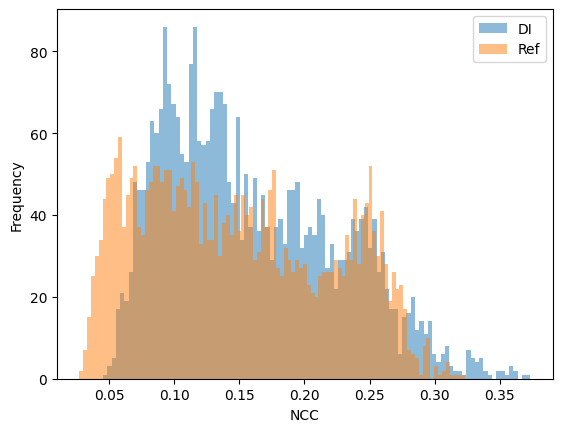

In [87]:
fig, ax = plt.subplots()
ax.hist(xmap_di.scores[:, 0], bins=100, color="C0", label="DI", alpha=0.5)
ax.hist(xmap_ref.scores, bins=100, color="C1", label="Ref", alpha=0.5)
ax.legend()
ax.set(xlabel="NCC", ylabel="Frequency");

Save final indexing results

In [88]:
io.save(path_res / "xmap_ref.ang", xmap_ref, overwrite=True)
io.save(path_res / "xmap_ref.h5", xmap_ref, overwrite=True)

Compare to simulations

In [89]:
sim_ref = simulator.on_detector(det1, xmap_ref.rotations.reshape(*xmap_ref.shape))

Finding bands that are in some pattern:
[########################################] | 100% Completed | 105.72 ms
Finding zone axes that are in some pattern:
[########################################] | 100% Completed | 106.18 ms
Calculating detector coordinates for bands and zone axes:
[########################################] | 100% Completed | 106.65 ms


In [90]:
markers = sim_ref.as_markers(lines_kwargs={"linewidth": 0.5})

In [91]:
del s.metadata.Markers
s.add_marker(markers, permanent=True, plot_marker=False)

Create a navigator from the IPF-Z map

In [92]:
maps_ipf = kp.draw.get_rgb_navigator(rgb_ref.reshape(xmap_ref.shape + (3,)))

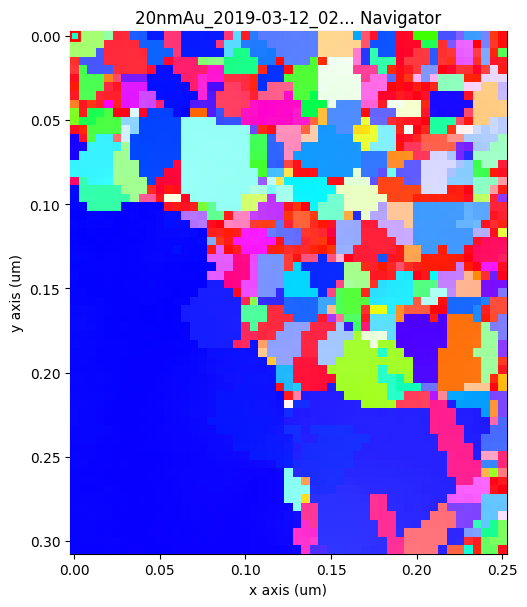

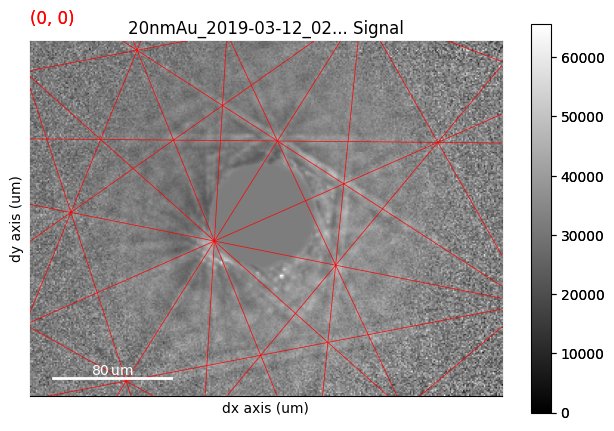

In [93]:
s.plot(maps_ipf)

Compare IPF maps from all four indexing routes

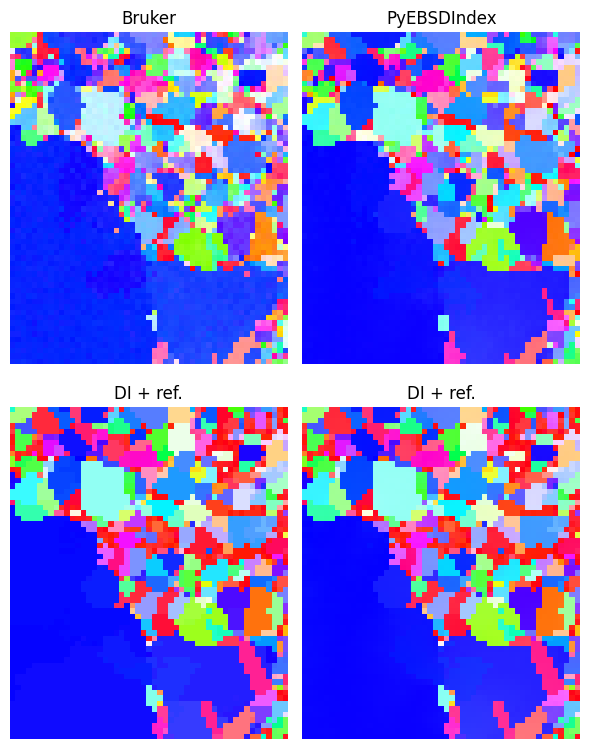

In [94]:
fig, axes = plt.subplots(2, 2, figsize=(6, 8), layout="tight")
for ax, rgb_i, title in zip(
    axes.ravel(),
    [rgb_bruker, rgb_hi, rgb_di, rgb_ref],
    ["Bruker", "PyEBSDIndex", "DI + ref.", "DI + ref."]
):
    ax.imshow(rgb_i.reshape(xmap_ref.shape + (3,)))
    ax.set_title(title)
    ax.axis("off")
fig.savefig(path_res / "maps_ipf001.png", **savefig_kw)

## What next?

We have now indexed our patterns and validated the results.
A natural next step in the analysis of the orientation data may be to analyze the grain size and morphology, as well as their preferred orientation (texture).
The results produced here can be imported by e.g. [MTEX](https://mtex-toolbox.github.io/) or [DREAM.3D](https://www.dream3d.io/).
Happy orientation data analysis!